Wavelet denoising with PyWavelets
=====
by Christopher Schölzel

Author's Note:
------

This notebook is a documentation of my own learning process regarding wavelet denoising.
I have covered the basics of the wavelet transform in [another notebook](https://github.com/CSchoel/learn-wavelets/blob/master/wavelet-introduction.ipynb).
Here, I will therefore assume that the reader is familiar with the basics and dive right into denoising.

For a fast implementation of the DWT we will use [PyWavelets](http://www.pybytes.com/pywavelets/).

The problem
------

So, first of all, what is the problem that we want to solve?
Well, we have a signal that is distorted by some kind of noise (we assume white noise here).

In [ ]:
%matplotlib inline
# we will use numpy and matplotlib for all the following examples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pywt

def doppler(freqs, dt, amp_inc=10, t0=0, f0=np.pi*2):
    t = np.arange(len(freqs)) * dt + t0
    amp = np.linspace(1, np.sqrt(amp_inc), len(freqs))**2
    sig = amp * np.sin(freqs * f0 * t)
    return t,sig

def noisify(sig, noise_amp=1):
    return sig + (np.random.random(len(sig))-0.5)*2*noise_amp
    

t_dop, sig_dop = doppler(np.arange(10,20,0.01)[::-1], 0.002)
sig_dop_n2 = noisify(sig_dop, noise_amp=2)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(t_dop, sig_dop)
plt.title("original signal")
plt.subplot(122)
plt.plot(t_dop, sig_dop_n2)
plt.title("noisy signal")
plt.show()

Our objective is to transform the signal on the right side back into the signal on the left side.
If we know the frequency range of the original signal, we could try to do this with an ideal low- or high-pass filter using the fourier transform.

In [ ]:
def fourier_denoising(sig, min_freq, max_freq, dt=1.0):
    trans = np.fft.fft(sig)
    freqs = np.fft.fftfreq(len(sig), d=dt)
    trans[np.where(np.logical_or(np.abs(freqs) < min_freq, np.abs(freqs) > max_freq))] = 0
    res = np.fft.ifft(trans)
    return res.real

fsig_dop = np.abs(np.fft.fft(sig_dop))
fsig_dop_n2 = np.abs(np.fft.fft(sig_dop_n2))
freqs_dop = np.fft.fftfreq(len(sig_dop),d=0.002)
idx = np.where(np.abs(freqs_dop) < 50)
plt.plot(freqs_dop[idx], fsig_dop[idx], label="fft(signal)")
plt.plot(freqs_dop[idx], fsig_dop_n2[idx], label="fft(signal + noise)")
plt.legend(loc="best")
plt.show()

fsig_dop_fden = fourier_denoising(sig_dop_n2, 0, 20, dt=0.002)
plt.plot(t_dop, sig_dop, lw=6, alpha=0.3, label="signal w/o. noise")
plt.plot(t_dop, fsig_dop_fden, "r-", label="denoising result")
plt.legend(loc="best")
plt.show()

This approach works reasonably well assuming that the frequency range of the original sequence is known.
This may be the case e.g. for sound data, but still the fourier filters do not address the part of the noise that falls within this frequency range.

As we learned before, the discrete wavelet transform is similar to a (windowed) fourier transform and thus there exist approaches for wavelet denoising that are similar to this cropping of frequency ranges.
Before we can have a look into wavelet denoising, we first have to make ourselves familiar with the DWT implementation provided by PyWavelets.

In [ ]:
# print the wavelet families available
print(pywt.families())
# print a list of available wavelets from one family
print(pywt.wavelist("sym"))

In [ ]:
# the haar wavelet
haar = pywt.Wavelet("haar")
h, g, hr, gr = haar.filter_bank
print("Haar wavelet highpass filter:",h)
print("Haar wavelet lowpass filter: ",g)
print(haar) # prints a summary of the wavelet properties

In [ ]:
# Daubechies "least asymmetric" wavelets with 12 vanishing points
sym12 = pywt.Wavelet("sym12")
phi_s12, psi_s12, x_s12 = sym12.wavefun(8)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(x_s12,phi_s12)
plt.subplot(122)
plt.plot(x_s12,psi_s12)
plt.show()

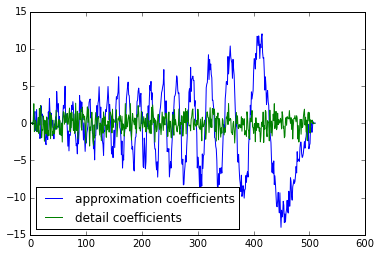

In [208]:
cA, cD = pywt.dwt(sig_dop_n2, "sym12", mode="zero")
plt.plot(cA, label="approximation coefficients")
plt.plot(cD, label="detail coefficients")
plt.legend(loc="best")
plt.show()

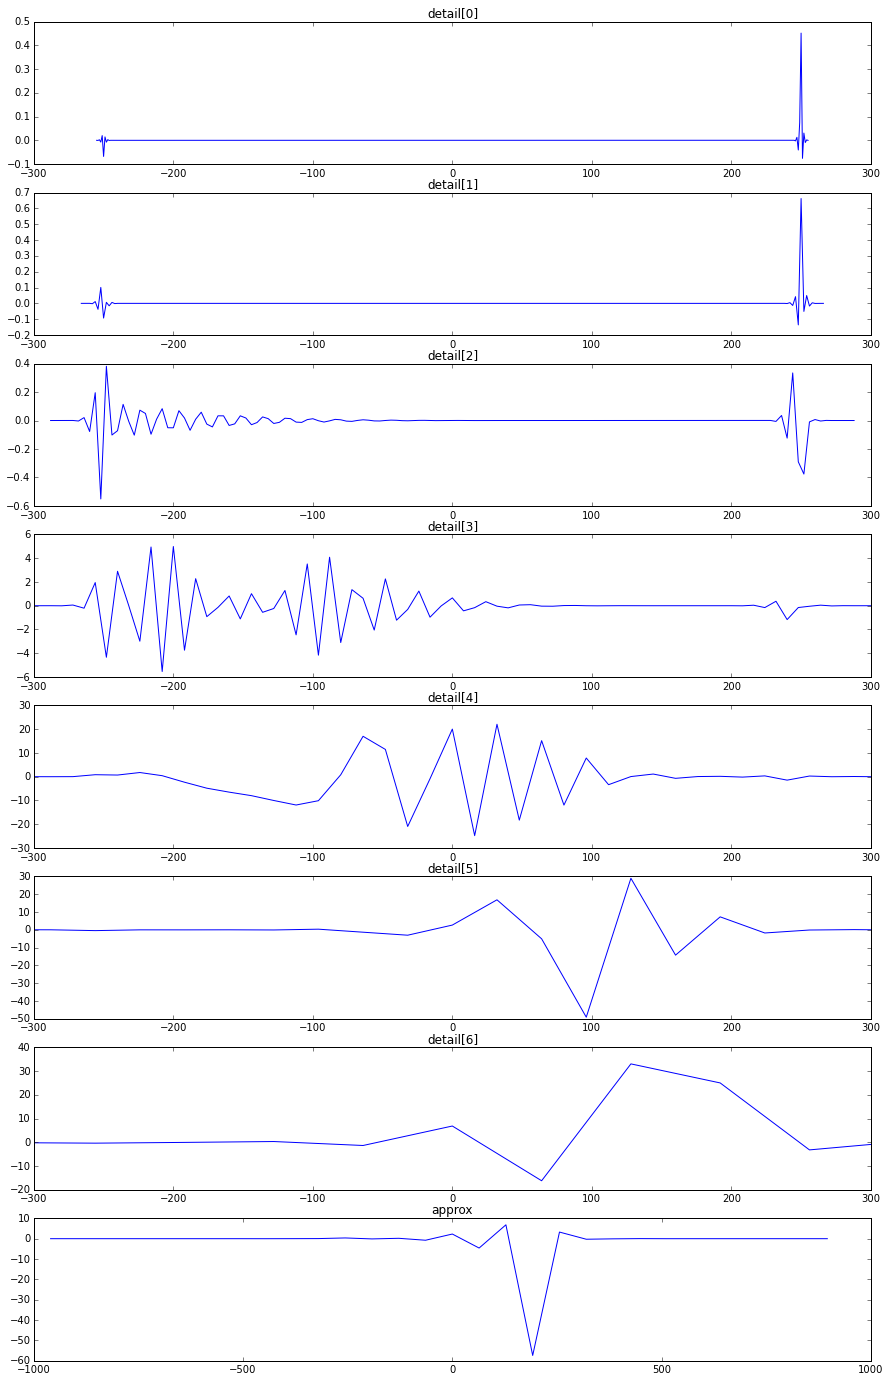

In [233]:
approx = sig_dop
details = []
while (len(approx) > 30):
    approx, detail = pywt.dwt(approx, "sym12", mode="zero")
    details.append(detail)
plt.figure(figsize=(15,24))
for i in range(len(details)):
    plt.subplot(len(details)+1,1,i+1)
    d = details[i]
    half = len(d)//2
    xvals = np.arange(-half,-half+len(d))* 2**i
    plt.plot(xvals, d)
    plt.xlim((-300, 300))
    plt.title("detail[{}]".format(i))
plt.subplot(len(details)+1,1,len(details)+1)
plt.title("approx")
plt.plot(xvals, approx)
plt.show()